Heart attacks kill 21 Australians every day [1]. The most common symptom is chest pain, however the presence of chest pain itself does not necessarily mean that a heart attack will follow. When combined with other observations, such as a patient's blood pressure, cholestoral level, and electrocardiographic (ECG) results, we can get a much better idea of the likelihood that a patient is at risk of suffering a heart attack.

This model will use demographic and clinical characteristics of patients presenting to hospital with chest pain, in order to identify those most at risk of suffering a heart attack, allowing them to receive potentially life-saving early treatment.


### About the dataset:

- `age`: age of the patient
- `sex`: sex of the patient
- `exng`: exercise induced angina (1 = yes; 0 = no)
- `caa`: number of major vessels (0-3)
- `cp`: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- `trtbps`: resting blood pressure (in mm Hg)
- `chol`: cholestoral in mg/dl fetched via BMI sensor
- `fbs`: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- `restecg`: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `thalachh`: maximum heart rate achieved
- `thall`: thalassemia
    - Value 0: null
    - Value 1: fixed defect
    - Value 2: normal
    - Value 3: reversable defect
- `oldpeak`: ST depression induced by exercise relative to rest
- `slp`: the slope of the peak exercise ST segment
- `output`: 
    - 0 = < 50% diameter narrowing; less chance of heart attack
    - 1 = > 50% diameter narrowing; more chance of heart attack


[1] https://www.healthdirect.gov.au/heart-attack

# Setup

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

In [2]:
DATA_PATH = './data/heart.csv'

# EDA

In [3]:
df = pd.read_csv(DATA_PATH)
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [6]:
features = {
    'age': {
        'description': 'age of the patient',
    },
    'sex': {
        'description': 'sex of the patient',
        'values': {
            '0': 'male',
            '1': 'female',
        },
    },
    'exng': {
        'description': 'exercise induced angina',
        'values': {
            '1': 'yes',
            '0': 'no',
        },
    },
    'caa': {
        'description': 'number of major vessels (0-3)',
    },
    'cp': {
        'description': 'chest pain type',
        'values': {
            '0': 'typical angina',
            '1': 'atypical angina',
            '2': 'non-anginal pain',
            '3': 'asymptomatic',
        },
    },
    'trtbps': {
        'description': 'resting blood pressure (in mm Hg)'
    },
    'chol': {
        'description': 'cholestoral in mg/dl fetched via BMI sensor'
    },
    'fbs': {
        'description': 'fasting blood sugar > 120 mg/dl',
        'values': {
            '1': 'true',
            '0': 'false',
        },
    },
    'restecg': {
        'description': 'resting electrocardiographic results',
        'values': {
            '0': 'normal',
            '1': 'having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV',
            '2': 'showing probable or definite left ventricular hypertrophy by Estes'' criteria',
        },
    },
    'thalachh': {
        'description': 'maximum heart rate achieved'
    },
    'thall': {
        'description': 'thalassemia',
        'values': {
            '0': 'null',
            '1': 'fixed defect',
            '2': 'normal',
            '3': 'reversable defect',
        },
    },
    'oldpeak': {
        'description': 'ST depression induced by exercise relative to rest',
    },
    'slp': {
        'description': 'the slope of the peak exercise ST segment',
        'values': {
            '0': 'unsloping',
            '1': 'flat',
            '2': 'downsloping',
        }
    },
    'output': {
        'description': 'target',
        'values': {
            '0': '< 50% diameter narrowing - less chance of heart attack',
            '1': '> 50% diameter narrowing - more chance of heart attack',
        },
    },
}

In [7]:
categorical = [
    'sex',
    'exng',
    'cp',
    'fbs',
    'restecg',
    'thall',
]

numerical = [
    'age',
    'caa',
    'trtbps',
    'chol',
    'thalachh',
    'oldpeak',
    'slp',
]

target = 'output'

In [8]:
# check unique values for categorical features

for column in df[categorical].columns:
    print(f"{column.upper()}: {features[column]['description']}")
    print(df[column].unique()[:5])
    print(df[column].nunique())
    print()

SEX: sex of the patient
[1 0]
2

EXNG: exercise induced angina
[0 1]
2

CP: chest pain type
[3 2 1 0]
4

FBS: fasting blood sugar > 120 mg/dl
[1 0]
2

RESTECG: resting electrocardiographic results
[0 1 2]
3

THALL: thalassemia
[1 2 3 0]
4



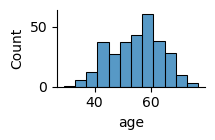

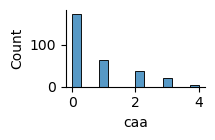

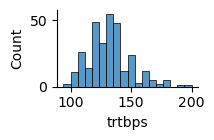

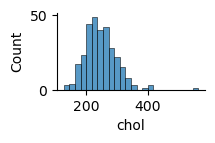

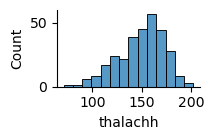

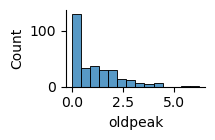

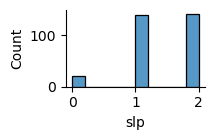

In [9]:
# check distributions of numerical features

for column in df[numerical].columns:
    sns.displot(
        data=df[column],
        height=1.5,
        aspect=1.5,
    )
    plt.show()

In [10]:
# check distribution of target variable

df.output.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: output, dtype: float64

In [11]:
heart_attack_rate = df.output.mean()
heart_attack_rate

0.5445544554455446

In [12]:
# check for missing values

df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [13]:
# check risk ratio of categorical features to outcome

for feature in categorical:
    print(f"{feature.upper()}: {features[feature]['description']}")
    print(features[feature]['values'])
    df_group = df.groupby(feature).output.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - heart_attack_rate
    df_group['risk'] = df_group['mean'] / heart_attack_rate
    display(df_group)
    print()

SEX: sex of the patient
{'0': 'male', '1': 'female'}


,mean,count,diff,risk
sex,,,,
0,0.750000,96,0.205446,1.377273
1,0.449275,207,-0.095279,0.825033



EXNG: exercise induced angina
{'1': 'yes', '0': 'no'}


,mean,count,diff,risk
exng,,,,
0,0.696078,204,0.151524,1.278253
1,0.232323,99,-0.312231,0.426630



CP: chest pain type
{'0': 'typical angina', '1': 'atypical angina', '2': 'non-anginal pain', '3': 'asymptomatic'}


,mean,count,diff,risk
cp,,,,
0,0.272727,143,-0.271827,0.500826
1,0.820000,50,0.275446,1.505818
2,0.793103,87,0.248549,1.456426
3,0.695652,23,0.151098,1.277470



FBS: fasting blood sugar > 120 mg/dl
{'1': 'true', '0': 'false'}


,mean,count,diff,risk
fbs,,,,
0,0.550388,258,0.005833,1.010712
1,0.511111,45,-0.033443,0.938586



RESTECG: resting electrocardiographic results
{'0': 'normal', '1': 'having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV', '2': 'showing probable or definite left ventricular hypertrophy by Estes criteria'}


,mean,count,diff,risk
restecg,,,,
0,0.462585,147,-0.081969,0.849474
1,0.631579,152,0.087024,1.159809
2,0.250000,4,-0.294554,0.459091



THALL: thalassemia
{'0': 'null', '1': 'fixed defect', '2': 'normal', '3': 'reversable defect'}


,mean,count,diff,risk
thall,,,,
0,0.500000,2,-0.044554,0.918182
1,0.333333,18,-0.211221,0.612121
2,0.783133,166,0.238578,1.438116
3,0.239316,117,-0.305238,0.439472


In [14]:
# define function to check mutual information between categorical features and target

def mutual_info_heart_attack_score(series):
    return mutual_info_score(series, df.output)

In [15]:
mutual_information = df[categorical].apply(mutual_info_heart_attack_score)
mutual_information.sort_values(ascending=False)

thall      0.147814
cp         0.141817
exng       0.098573
sex        0.040992
restecg    0.016687
fbs        0.000392
dtype: float64

In [16]:
# check correlation between numerical features and target

df[numerical + [target]].corr()

,age,caa,trtbps,chol,thalachh,oldpeak,slp,output
age,1.000000,0.276326,0.279351,0.213678,-0.398522,0.210013,-0.168814,-0.225439
caa,0.276326,1.000000,0.101389,0.070511,-0.213177,0.222682,-0.080155,-0.391724
trtbps,0.279351,0.101389,1.000000,0.123174,-0.046698,0.193216,-0.121475,-0.144931
chol,0.213678,0.070511,0.123174,1.000000,-0.009940,0.053952,-0.004038,-0.085239
thalachh,-0.398522,-0.213177,-0.046698,-0.009940,1.000000,-0.344187,0.386784,0.421741
oldpeak,0.210013,0.222682,0.193216,0.053952,-0.344187,1.000000,-0.577537,-0.430696
slp,-0.168814,-0.080155,-0.121475,-0.004038,0.386784,-0.577537,1.000000,0.345877
output,-0.225439,-0.391724,-0.144931,-0.085239,0.421741,-0.430696,0.345877,1.000000


# Prepare features

In [27]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=0)

len(df_train), len(df_val), len(df_test)

(193, 49, 61)

In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.output.values
y_val = df_val.output.values
y_test = df_test.output.values

del df_train['output']
del df_val['output']
del df_test['output']

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')


In [49]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

# Train models

### Logistic Regression

In [31]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
y_pred = lr_model.predict_proba(X_val)[:, 1]

In [33]:
roc_auc_score(y_val, y_pred)

0.8068181818181819

In [34]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

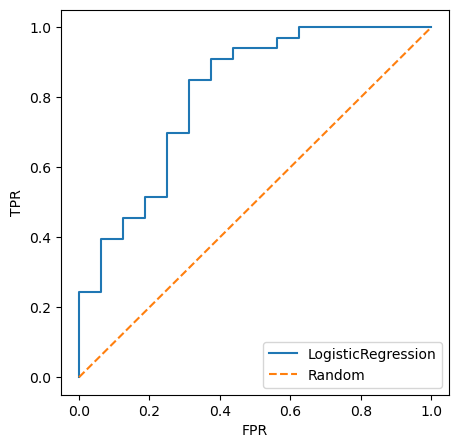

In [35]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='LogisticRegression')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### XGBoost

In [59]:
features = dv.get_feature_names_out()
d_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [37]:
xgb_parameters  = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 0,
    'verbosity': 1,
}

watch_list = [(d_train, 'train'), (d_val, 'val')]

In [38]:
xgb_model = xgb.train(
    xgb_parameters,
    d_train,
    num_boost_round=25,
    evals=watch_list
)

[0]	train-auc:0.96917	val-auc:0.73390
[1]	train-auc:0.97954	val-auc:0.75568
[2]	train-auc:0.98405	val-auc:0.78788
[3]	train-auc:0.98722	val-auc:0.76989
[4]	train-auc:0.99146	val-auc:0.77936
[5]	train-auc:0.99506	val-auc:0.79072
[6]	train-auc:0.99603	val-auc:0.78883
[7]	train-auc:0.99721	val-auc:0.80019
[8]	train-auc:0.99764	val-auc:0.80019
[9]	train-auc:0.99839	val-auc:0.81250
[10]	train-auc:0.99903	val-auc:0.80871
[11]	train-auc:0.99957	val-auc:0.81061
[12]	train-auc:0.99968	val-auc:0.79735
[13]	train-auc:0.99989	val-auc:0.79167
[14]	train-auc:0.99979	val-auc:0.79545
[15]	train-auc:0.99989	val-auc:0.79167
[16]	train-auc:0.99989	val-auc:0.79356
[17]	train-auc:0.99989	val-auc:0.79545
[18]	train-auc:1.00000	val-auc:0.79545
[19]	train-auc:1.00000	val-auc:0.79167
[20]	train-auc:1.00000	val-auc:0.79356
[21]	train-auc:1.00000	val-auc:0.79356
[22]	train-auc:1.00000	val-auc:0.79735
[23]	train-auc:1.00000	val-auc:0.79356
[24]	train-auc:1.00000	val-auc:0.79545


In [39]:
y_pred = xgb_model.predict(d_val)

In [40]:
roc_auc_score(y_val, y_pred)

0.7954545454545454

In [258]:
# define function to parse XGBoost output

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [266]:
%%capture output

xgb_parameters  = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 0,
    'verbosity': 1,
}

watch_list = [(d_train, 'train'), (d_val, 'val')]

xgb_model = xgb.train(
    xgb_parameters,
    d_train,
    num_boost_round=200,
    evals=watch_list
)

In [267]:
df_score = parse_xgb_output(output)

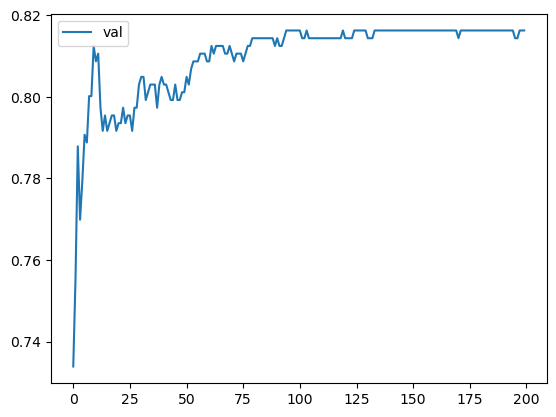

In [270]:
# plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### XGBoost Parameter Tuning

##### ETA

In [271]:
scores = {}

In [280]:
%%capture output

xgb_parameters = {
    'eta': 1, # try 0.01, 0.05, 0.1, 0.5, 1
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=200,
    verbose_eval=5,
    evals=watch_list
)

In [281]:
key = 'eta=%s' % (xgb_parameters['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

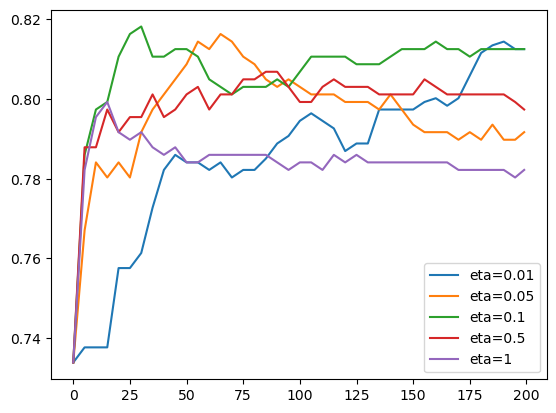

In [282]:
etas = [
    'eta=0.01',
    'eta=0.05',
    'eta=0.1',
    'eta=0.5',
    'eta=1', 
]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

##### Max Depth

In [283]:
scores = {}

In [294]:
%%capture output

xgb_parameters = {
    'eta': 0.1, # best eta from previous experiment 
    'max_depth': 1, # try 1,2,3,4,5,6
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=200,
    verbose_eval=5,
    evals=watch_list
)

In [295]:
key = 'max_depth=%s' % (xgb_parameters['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=1'

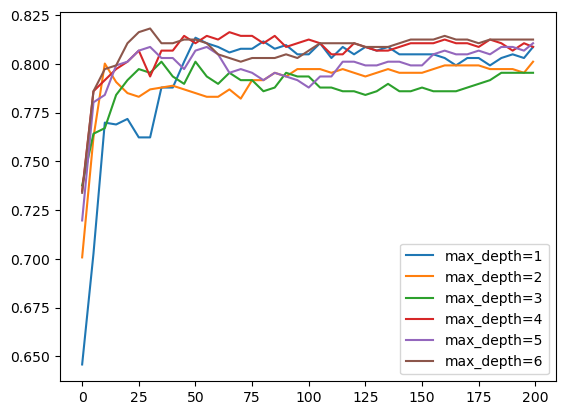

In [296]:
max_depths = [
    'max_depth=1',
    'max_depth=2',
    'max_depth=3',
    'max_depth=4',
    'max_depth=5',
    'max_depth=6'
]

for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

##### Min Child Weight

In [ ]:
scores = {}

In [305]:
%%capture output

xgb_parameters = {
    'eta': 0.1, # best eta from previous experiment 
    'max_depth': 6, # best max_depth from previous experiment
    'min_child_weight': 0, # try 0,1,5,10,20
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=200,
    verbose_eval=5,
    evals=watch_list
)

In [306]:
key = 'min_child_weight=%s' % (xgb_parameters['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=0'

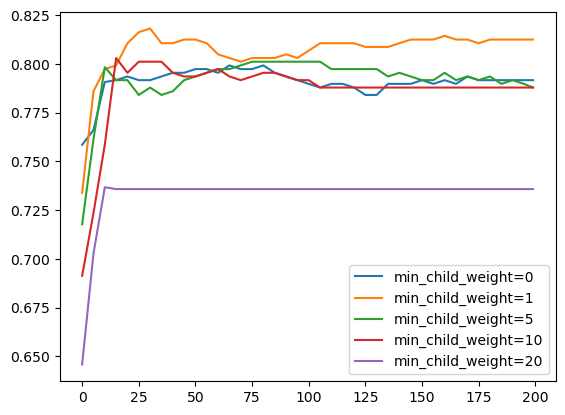

In [307]:
min_child_weights = [
    'min_child_weight=0',
    'min_child_weight=1',
    'min_child_weight=5',
    'min_child_weight=10',
    'min_child_weight=20',
]

for min_child_weight in min_child_weights:
    df_score = scores[min_child_weight]
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

# Select best model

### Logistic Regression

In [308]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [309]:
y_pred = lr_model.predict_proba(X_val)[:, 1]

In [310]:
roc_auc_score(y_val, y_pred)

0.8068181818181819

### XGBoost

In [41]:
xgb_parameters = {
    'eta': 0.1, # best eta from previous experiment 
    'max_depth': 6, # best max_depth from previous experiment
    'min_child_weight': 1, # best min_child_weight from previous experiment
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=30,
    verbose_eval=5,
)

In [42]:
y_pred = xgb_model.predict(d_val)

In [43]:
roc_auc_score(y_val, y_pred)

0.8200757575757576

In [50]:
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.output.values

del df_full_train['output']

full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)

In [60]:
features = dv.get_feature_names_out()
d_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
d_test = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [61]:
xgb_parameters = {
    'eta': 0.1, # best eta from previous experiment 
    'max_depth': 6, # best max_depth from previous experiment
    'min_child_weight': 1, # best min_child_weight from previous experiment
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_full_train, 
    num_boost_round=30,
    verbose_eval=5,
)

In [62]:
y_pred = xgb_model.predict(d_test)

In [63]:
roc_auc_score(y_test, y_pred)

0.9193899782135077